# Data cleansing and feature engineering

We will start our study with data cleansing and wrangling to:

- structure and organize the data
- clean the data
    - wrong data types
    - remove duplicates (if any)
- enrich the data
    - decide how to deal with empty entries (if any)


## Getting to know the data

Let's start importing the necessary libraries and loading the data.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from churn.config import RAW_DATA_FILE, INTERIM_DATA_FILE
from churn.utils import best_grid_shape

In [2]:
df = pd.read_csv(RAW_DATA_FILE, compression="zip")

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


There are some inconsistencies in the data representation.

Considering the categorical column `SeniorCitizen` first. All other categorical columns
have strings as entries, like *Yes* or *No*. In the `SeniorCitizen` column, 0 means *No*
and 1 means Yes*.

The columns `gender` and `tenure` will be renamed to capitalize the first letter of each
word.  This way, they will be consistent with the other columns.

Finally, there are some payment methods with long names. We will replace them with
shorter names.

In [3]:
# map the values of the column SeniorCitizen to No and Yes for consistency with other columns
df['SeniorCitizen'] = df['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

# rename gender to Gender and tenure to Tenure for consistency with other columns
df = df.rename(columns={"gender": "Gender", "tenure": "Tenure"})

# remove " (automatic)" from column PaymentMethod to make it more readable
df["PaymentMethod"] = df["PaymentMethod"].str.replace(" (automatic)", "")

Let's check now the info and describe of the data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
with pd.option_context(
    "display.float_format", "{:.2f}".format, "display.max_columns", None
):
    display(df.describe())

,Tenure,MonthlyCharges
count,7043.00,7043.00
mean,32.37,64.76
std,24.56,30.09
min,0.00,18.25
25%,9.00,35.50
50%,29.00,70.35
75%,55.00,89.85
max,72.00,118.75


In [6]:
df.describe(exclude="number")

,customerID,Gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,3186-AJIEK,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,,No
freq,1,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


Considering the `describe` of categorical columns, we know that most customers:

- are male
- are younger than 65 years
- have no partner and no dependents
- have phone service, with a single line
- have fiber optic internet service
- do not have online services (security, backup, device protection)
- do not have tech support
- do not have streaming services
- have monthly contracts
- have paperless billing and pay with electronic check


It appears that there are no missing values. However, the `TotalCharges` column should be
float type. Probably it is being recognized as object due to some empty entries recorded
as strings with spaces. Let's check:

In [7]:
# check if there are spaces in the column TotalCharges
df['TotalCharges'].str.isspace().sum()

np.int64(11)

Removing the spaces and converting the column to float type:

In [8]:
# replace the spaces with NaN (regex for single or multiple spaces)
df['TotalCharges'] = df['TotalCharges'].replace(r'^\s*$', np.nan, regex=True)

# convert TotalCharges to float
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [9]:
with pd.option_context(
    "display.float_format", "{:.2f}".format, "display.max_columns", None
):
    display(df.describe())

,Tenure,MonthlyCharges,TotalCharges
count,7043.00,7043.00,7032.00
mean,32.37,64.76,2283.30
std,24.56,30.09,2266.77
min,0.00,18.25,18.80
25%,9.00,35.50,401.45
50%,29.00,70.35,1397.47
75%,55.00,89.85,3794.74
max,72.00,118.75,8684.80


Now the type is correct and we have 11 missing values. Let's check them:

In [10]:
df.loc[df["TotalCharges"].isnull()]

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer,52.55,NaN,No
753,3115-CZMZD,Male,No,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card,56.05,NaN,No
3331,7644-OMVMY,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


As described in the data dictionary, the total charges are summed up quarterly, so new
customers will not have entries. We can check that these entries are from new customers
with 0 tenure:

In [11]:
df.loc[df["Tenure"] == 0][["customerID", "Tenure", "MonthlyCharges", "TotalCharges"]]

,customerID,Tenure,MonthlyCharges,TotalCharges
488,4472-LVYGI,0,52.55,NaN
753,3115-CZMZD,0,20.25,NaN
936,5709-LVOEQ,0,80.85,NaN
1082,4367-NUYAO,0,25.75,NaN
1340,1371-DWPAZ,0,56.05,NaN
3331,7644-OMVMY,0,19.85,NaN
3826,3213-VVOLG,0,25.35,NaN
4380,2520-SGTTA,0,20.00,NaN
5218,2923-ARZLG,0,19.70,NaN
6670,4075-WKNIU,0,73.35,NaN


We could remove `TotalCharges` empty rows since is a small percentage of the dataset.
However, these rows are legit as they correspond to new customers (`Tenure == 0`).
We can repeat the values from `MonthlyCharges` to `TotalCharges` for these rows:

In [12]:
# fill the NaN values with the MonthlyCharges values in the same row
df["TotalCharges"] = df["TotalCharges"].fillna(df["MonthlyCharges"])

df.loc[df["Tenure"] == 0][["customerID", "Tenure", "MonthlyCharges", "TotalCharges"]]

,customerID,Tenure,MonthlyCharges,TotalCharges
488,4472-LVYGI,0,52.55,52.55
753,3115-CZMZD,0,20.25,20.25
936,5709-LVOEQ,0,80.85,80.85
1082,4367-NUYAO,0,25.75,25.75
1340,1371-DWPAZ,0,56.05,56.05
3331,7644-OMVMY,0,19.85,19.85
3826,3213-VVOLG,0,25.35,25.35
4380,2520-SGTTA,0,20.00,20.00
5218,2923-ARZLG,0,19.70,19.70
6670,4075-WKNIU,0,73.35,73.35


Checking the modified data:

In [13]:
df.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer,42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [15]:
with pd.option_context(
    "display.float_format", "{:.2f}".format, "display.max_columns", None
):
    display(df.describe())

,Tenure,MonthlyCharges,TotalCharges
count,7043.00,7043.00,7043.00
mean,32.37,64.76,2279.80
std,24.56,30.09,2266.73
min,0.00,18.25,18.80
25%,9.00,35.50,398.55
50%,29.00,70.35,1394.55
75%,55.00,89.85,3786.60
max,72.00,118.75,8684.80


Let's take a look at our target column, `Churn`:

In [16]:
df["Churn"].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [17]:
df["Churn"].value_counts(normalize=True).mul(100).round(2)

Churn
No     73.46
Yes    26.54
Name: proportion, dtype: float64

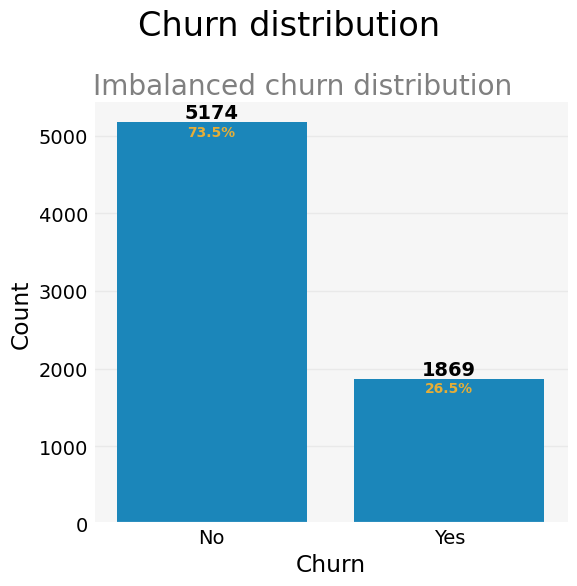

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(data=df, x="Churn", ax=ax)

ax.bar_label(
    ax.containers[0],
    label_type="edge",
    weight="bold",
    labels=df["Churn"].value_counts(),
)

ax.bar_label(
    ax.containers[0],
    label_type="edge",
    weight="bold",
    labels=map(lambda num: f"{num:.1%}", df["Churn"].value_counts(normalize=True)),
    padding=-12,
    fontsize=10,
    color="C2",
)

ax.set_xlabel("Churn")
ax.set_ylabel("Count")
ax.set_title("Imbalanced churn distribution")

fig.suptitle("Churn distribution")

plt.show()

We see that we have a class imbalance. This is important to keep in mind when setting up
our models. We will address this later.

## Outlier detection

In this section, we will look for outliers in our data. Outliers are data points that are significantly different from the rest of the data. 

In [19]:
numeric_features = df.select_dtypes(include="number").columns

target = "Churn"

id_column = "customerID"

categorical_features = df.select_dtypes(exclude="number").columns.drop(
    [target, id_column]
)

In [20]:
display(numeric_features)
display(categorical_features)

Index(['Tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

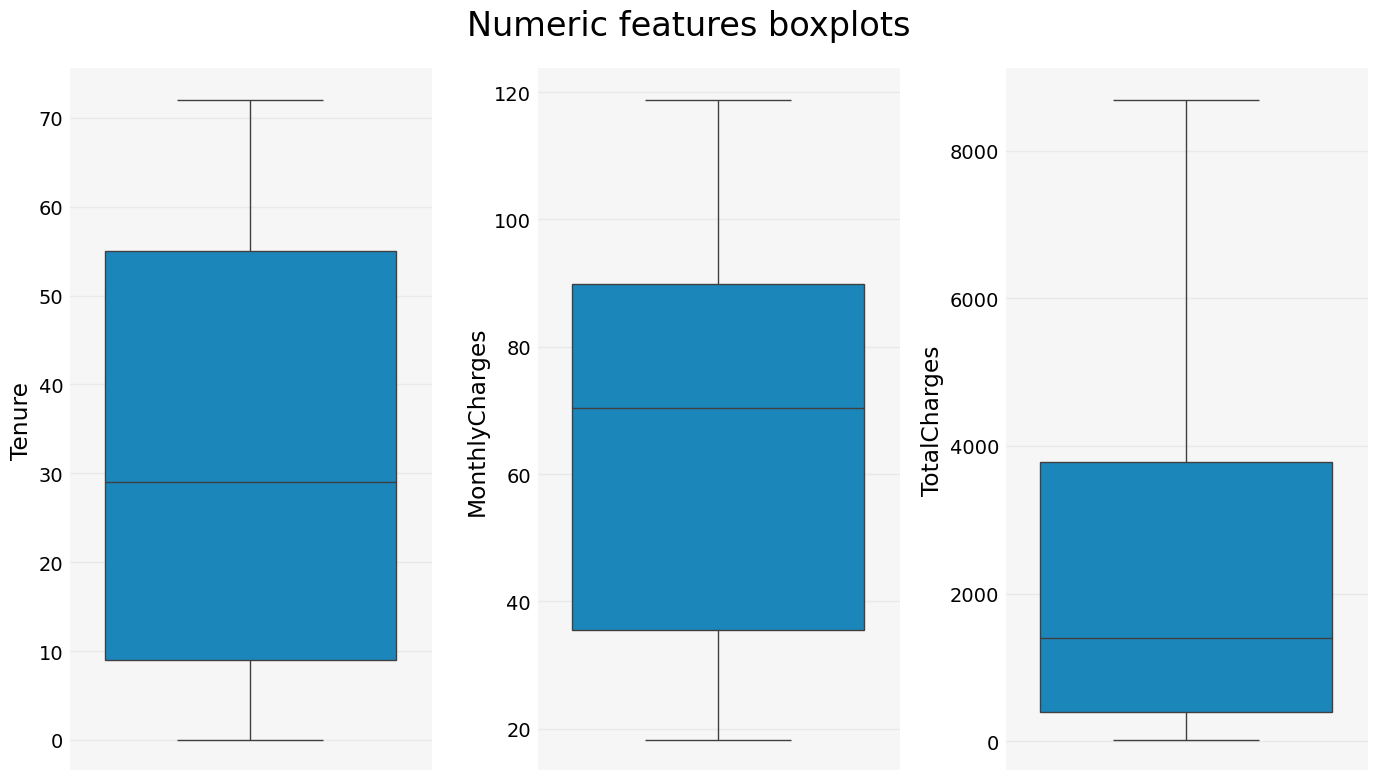

In [21]:
fig, axs = plt.subplots(*best_grid_shape(len(numeric_features)), tight_layout=True)

for ax, feature in zip(axs.flat, numeric_features):
    sns.boxplot(data=df, y=feature, ax=ax)

fig.suptitle("Numeric features boxplots")

plt.show()

As can be seen, none of the numerical columns have outliers.
But, since we are dealing with a classification problem, and with a class
imbalance, we need to have a more careful approach to the outliers considering the
target variable. We will analyze the outliers for each class separately:

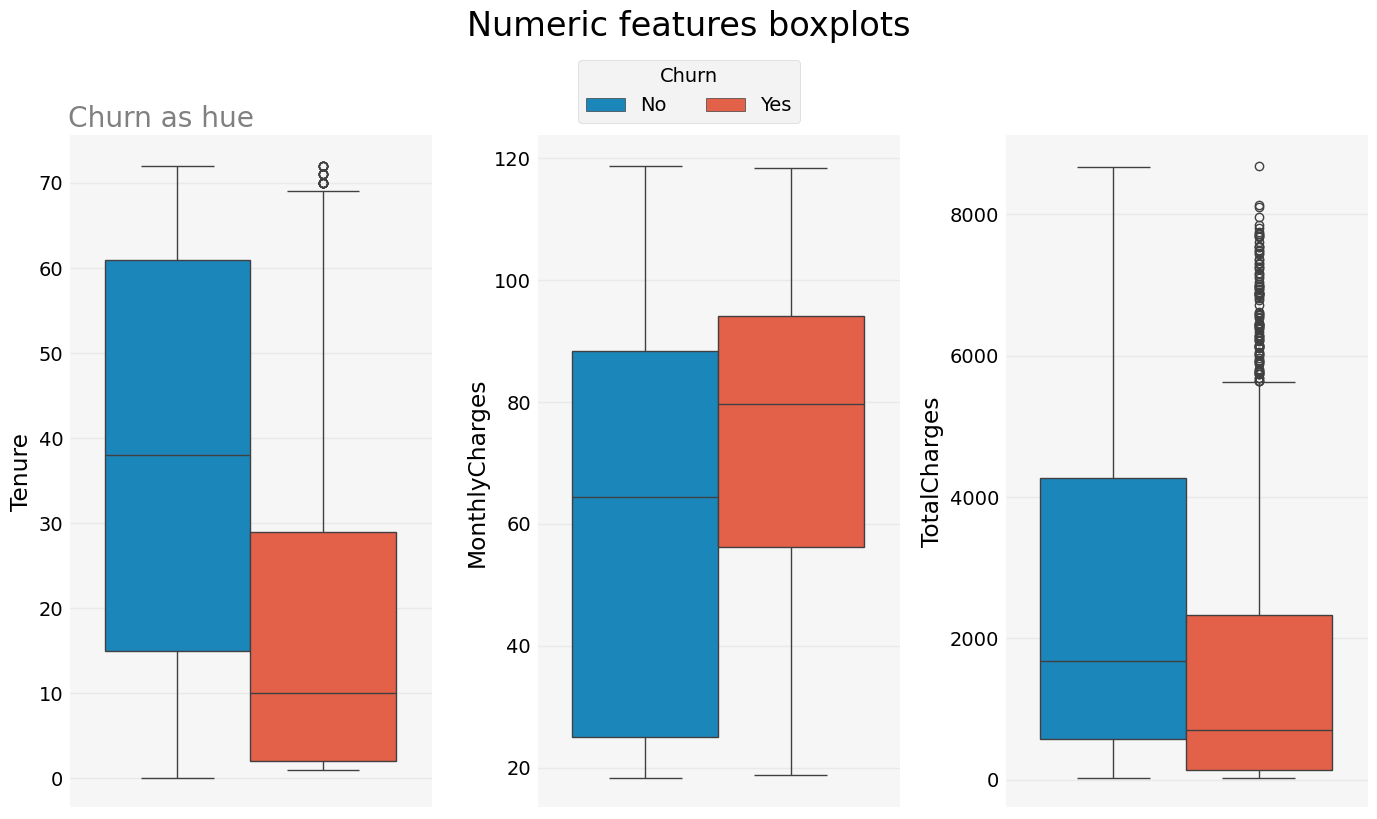

In [22]:
fig, axs = plt.subplots(*best_grid_shape(len(numeric_features)), tight_layout=True)

for ax, feature in zip(axs.flat, numeric_features):
    b = sns.boxplot(data=df, y=feature, ax=ax, hue="Churn")

    legend = b.get_legend()
    legend.remove()

labels = [text.get_text() for text in legend.get_texts()]

fig.legend(
    handles=legend.legend_handles,
    labels=labels,
    loc="upper center",
    ncols=df[target].nunique(),
    title="Churn",
    bbox_to_anchor=(0.5, 0.975),
)

axs[0].set_title("Churn as hue")
fig.suptitle("Numeric features boxplots", y=1.025)

plt.show()

The boxplots show that the churn rate is higher among customers with low tenure and high
monthly charges. In details:

- the median tenure for customers who have left is around 10 months, while it is around
40 months for those who have stayed with the company. So, customers who have churned
spent less time with the company.
- the median monthly charge for customers who have churned is around 80, while it is
around 65 for those who have not churned. Therefore, customers who have churned have
higher monthly charges.
- since most customers who have churned spent less time with the company, they have low
median total charges compared with those who have stayed
   - There are some outliers in the total charges boxplot of customers who have churned.
   This shows that some customers who have churned have high total charges, even though
   they have spent less time with the company. This could be due to high monthly
   charges. Since the data is consistent, we will keep these outliers.




## Categorical columns

We have plenty of categorical columns. It is important to type them as category to save
memory and to facilitate the analysis:


In [23]:
df.columns[(df.nunique() == 2) & (df.dtypes != "category")]

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'Churn'],
      dtype='object')

In [24]:
for column in df.columns[(df.nunique() == 2) & (df.dtypes != "category")]:
    if column == "Gender":
        df[column] = pd.Categorical(
            df[column], categories=("Female", "Male"), ordered=False
        )
    else:
        df[column] = pd.Categorical(df[column], categories=("No", "Yes"), ordered=False)

In [25]:
for column in df.columns[(df.nunique() <= 5) & (df.dtypes != "category")]:
    # if the column has No it should be the first category, Yes the second, and the rest in alphabetical order
    unique_values = sorted(df[column].unique())
    categories = []
    if "No" in unique_values:
        unique_values.remove("No")
        categories.append("No")
    if "Yes" in unique_values:
        unique_values.remove("Yes")
        categories.append("Yes")
    categories.extend(unique_values)

    df[column] = pd.Categorical(df[column], categories=categories, ordered=False)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   Gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   Tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

In [27]:
# for each categorical feature, print the column name, the categories and the respective codes
for column in df.select_dtypes(include="category").columns:
    categories = df[column].cat.categories
    codes = df[column].cat.codes
    category_codes = {cat: i for i, cat in enumerate(categories)}

    print(f"{column:<18} | {category_codes}")

Gender             | {'Female': 0, 'Male': 1}
SeniorCitizen      | {'No': 0, 'Yes': 1}
Partner            | {'No': 0, 'Yes': 1}
Dependents         | {'No': 0, 'Yes': 1}
PhoneService       | {'No': 0, 'Yes': 1}
MultipleLines      | {'No': 0, 'Yes': 1, 'No phone service': 2}
InternetService    | {'No': 0, 'DSL': 1, 'Fiber optic': 2}
OnlineSecurity     | {'No': 0, 'Yes': 1, 'No internet service': 2}
OnlineBackup       | {'No': 0, 'Yes': 1, 'No internet service': 2}
DeviceProtection   | {'No': 0, 'Yes': 1, 'No internet service': 2}
TechSupport        | {'No': 0, 'Yes': 1, 'No internet service': 2}
StreamingTV        | {'No': 0, 'Yes': 1, 'No internet service': 2}
StreamingMovies    | {'No': 0, 'Yes': 1, 'No internet service': 2}
Contract           | {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
PaperlessBilling   | {'No': 0, 'Yes': 1}
PaymentMethod      | {'Bank transfer': 0, 'Credit card': 1, 'Electronic check': 2, 'Mailed check': 3}
Churn              | {'No': 0, 'Yes': 1}


In [28]:
with pd.option_context(
    "display.float_format", "{:.2f}".format, "display.max_columns", None
):
    display(df.head())

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer,42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [29]:
df["InternetService"].cat.codes

0       1
1       1
2       1
3       1
4       2
       ..
7038    1
7039    2
7040    1
7041    2
7042    2
Length: 7043, dtype: int8

## Memory optimization and final dataset export

We can diminish the memory usage by converting the integer columns to an integer type with less memory usage:

In [30]:
for column in df.select_dtypes(include="integer").columns:
    df[column] = pd.to_numeric(df[column], downcast="integer")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   Gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   Tenure            7043 non-null   int8    
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

To make the data easier to handle, we can reorder the columns:

In [31]:
# reorder columns: id, sorted categorical columns, sorted numeric columns, target column
sorted_columns = sorted(df.columns, key=lambda col: (df[col].dtype.name, col))
sorted_columns.remove(target)
sorted_columns.remove(id_column)
sorted_columns = [id_column] + sorted_columns + [target]
sorted_columns

['customerID',
 'Contract',
 'Dependents',
 'DeviceProtection',
 'Gender',
 'InternetService',
 'MultipleLines',
 'OnlineBackup',
 'OnlineSecurity',
 'PaperlessBilling',
 'Partner',
 'PaymentMethod',
 'PhoneService',
 'SeniorCitizen',
 'StreamingMovies',
 'StreamingTV',
 'TechSupport',
 'MonthlyCharges',
 'TotalCharges',
 'Tenure',
 'Churn']

In [32]:
# reorder the columns
df = df[sorted_columns]

df.head()

,customerID,Contract,Dependents,DeviceProtection,Gender,InternetService,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,...,PaymentMethod,PhoneService,SeniorCitizen,StreamingMovies,StreamingTV,TechSupport,MonthlyCharges,TotalCharges,Tenure,Churn
0,7590-VHVEG,Month-to-month,No,No,Female,DSL,No phone service,Yes,No,Yes,...,Electronic check,No,No,No,No,No,29.85,29.85,1,No
1,5575-GNVDE,One year,No,Yes,Male,DSL,No,No,Yes,No,...,Mailed check,Yes,No,No,No,No,56.95,1889.50,34,No
2,3668-QPYBK,Month-to-month,No,No,Male,DSL,No,Yes,Yes,Yes,...,Mailed check,Yes,No,No,No,No,53.85,108.15,2,Yes
3,7795-CFOCW,One year,No,Yes,Male,DSL,No phone service,No,Yes,No,...,Bank transfer,No,No,No,No,Yes,42.30,1840.75,45,No
4,9237-HQITU,Month-to-month,No,No,Female,Fiber optic,No,No,No,Yes,...,Electronic check,Yes,No,No,No,No,70.70,151.65,2,Yes


The parquet format is a columnar storage format that is efficient for reading and writing data. It is a good choice for storing datasets keeping the data types and the metadata. We can export the final dataset to a parquet file:

In [33]:
# fastparquet is better to handle the category type
df.to_parquet(INTERIM_DATA_FILE, index=False, engine="fastparquet")